## Coding an LLM Architecture

In [1]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## Normalizing Activations with Layer Normalization

In [5]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [6]:
layer = nn.Sequential(nn.Linear(5 , 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
mean = out.mean(dim = 1, keepdim=True)
mean

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

In [8]:
var = out.var(dim = 1, keepdim=True)
var

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

In [9]:
normed = ((out-mean) / torch.sqrt(var))
normed.mean(dim = -1, keepdim = True)

tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)

In [10]:
normed.var(dim = -1, keepdim = True)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        print("mean after norm:", norm_x.mean(dim=-1, keepdim=True))
        print("var after norm:", norm_x.var(dim=-1, keepdim=True, unbiased=False))
        return (self.scale * norm_x) + self.shift

In [12]:
ln = LayerNorm(6)
outputs_normed = ln(out)
outputs_normed

mean after norm: tensor([[ 1.9868e-08],
        [-1.9868e-08]], grad_fn=<MeanBackward1>)
var after norm: tensor([[0.9995],
        [0.9997]], grad_fn=<VarBackward0>)


tensor([[ 0.6745,  1.5470, -0.9549,  0.6431, -0.9549, -0.9549],
        [-0.0207,  0.1228, -1.1913,  1.6619,  0.6186, -1.1913]],
       grad_fn=<AddBackward0>)

In [13]:
outputs_normed.mean(dim = -1, keepdim=True)

tensor([[ 1.9868e-08],
        [-1.9868e-08]], grad_fn=<MeanBackward1>)

In [14]:
outputs_normed.var(dim = -1, keepdim=True, unbiased = False)

tensor([[0.9995],
        [0.9997]], grad_fn=<VarBackward0>)

## Implementing a Feed Forward Network with GELU activations

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.44715 * torch.pow(x, 3))
        ))

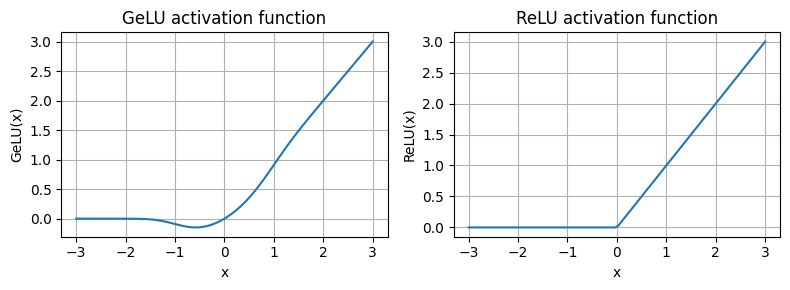

In [16]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GeLU', 'ReLU']), 1):
    plt.subplot(1,2,i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel('x')
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]),
            GELU(),
            nn.Linear(4* cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [18]:
ffn = FeedForward(cfg = GPT_CONFIG_124M)

In [19]:
x = torch.rand(2 , 3, 768)
ffn(x).shape

torch.Size([2, 3, 768])

## Adding Shortcut Connections

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcuts = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcuts and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [21]:
layer_size =  [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])

In [22]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_size=layer_size, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.000204713229322806
layers.1.0.weight has gradient mean of 0.00012317951768636703
layers.2.0.weight has gradient mean of 0.0007344746845774353
layers.3.0.weight has gradient mean of 0.0013871213886886835
layers.4.0.weight has gradient mean of 0.005026496481150389


In [23]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_size=layer_size, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.29920274019241333
layers.1.0.weight has gradient mean of 0.2749510407447815
layers.2.0.weight has gradient mean of 0.454661101102829
layers.3.0.weight has gradient mean of 0.3629586398601532
layers.4.0.weight has gradient mean of 1.763088583946228


## Connecting Attention and Linear Layers in a Transformer Block

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`, 
        # this will result in errors in the mask creation further below. 
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs  
        # do not exceed `context_length` before reaching this forwar

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # for Attention Block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # for Feed Forward Block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


In [26]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(cfg = GPT_CONFIG_124M)
output = block(x)
output

mean after norm: tensor([[[ 1.1052e-07],
         [-1.2914e-07],
         [-7.0781e-08],
         [ 1.4280e-07]],

        [[ 1.7385e-08],
         [-1.7975e-07],
         [-1.1828e-07],
         [-5.5724e-08]]])
var after norm: tensor([[[0.9999],
         [0.9999],
         [0.9999],
         [0.9999]],

        [[0.9999],
         [0.9999],
         [0.9999],
         [0.9999]]])
mean after norm: tensor([[[ 1.4901e-07],
         [-2.7319e-08],
         [-1.0058e-07],
         [-1.0928e-07]],

        [[-7.2022e-08],
         [-4.3462e-08],
         [-6.7055e-08],
         [-3.7253e-09]]], grad_fn=<MeanBackward1>)
var after norm: tensor([[[1.0000],
         [0.9999],
         [0.9999],
         [0.9999]],

        [[1.0000],
         [0.9999],
         [0.9999],
         [0.9999]]], grad_fn=<VarBackward0>)


tensor([[[-0.0219,  0.0557, -0.1409,  ...,  1.2803,  0.2563,  0.7062],
         [-0.0058, -0.2442,  0.1480,  ...,  0.6127,  0.2497,  0.7504],
         [ 0.4858,  0.4528,  0.1791,  ...,  1.2753,  0.2990,  0.7706],
         [ 0.0733,  0.7131,  0.9206,  ...,  0.4926,  0.7179,  0.7153]],

        [[ 0.3683,  1.2129,  0.5065,  ...,  0.1792,  0.0159, -0.5395],
         [-0.0238,  0.8010,  0.2696,  ...,  0.1589,  0.5254,  0.1016],
         [ 0.7309,  0.4011,  0.2974,  ...,  0.3366,  0.7703, -0.1489],
         [ 0.5745,  0.6229,  0.4328,  ...,  1.2015,  1.2629,  0.2273]]],
       grad_fn=<AddBackward0>)

## Coding The GPT Model

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [28]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

mean after norm: tensor([[[-3.7253e-09],
         [ 0.0000e+00],
         [ 1.8626e-08],
         [ 1.3659e-08]],

        [[-2.0179e-09],
         [-1.3970e-08],
         [-1.1176e-08],
         [-7.4506e-09]]], grad_fn=<MeanBackward1>)
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]], grad_fn=<VarBackward0>)
mean after norm: tensor([[[-1.4280e-08],
         [ 9.9341e-09],
         [-1.8626e-09],
         [-1.8626e-08]],

        [[ 5.5879e-09],
         [ 6.8297e-09],
         [-1.2418e-09],
         [-3.7253e-09]]], grad_fn=<MeanBackward1>)
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]], grad_fn=<VarBackward0>)
mean after norm: tensor([[[ 1.2418e-08],
         [ 2.4835e-09],
         [-8.6923e-09],
         [-2.4835e-09]],

        [[ 0.0000

In [30]:
batch.shape

torch.Size([2, 4])

In [31]:
out.shape

torch.Size([2, 4, 50257])

In [32]:
batch.numel()

8

In [33]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

In [37]:
total_params - model.out_head.weight.numel()

124412160

Exercise: you can try the following other configurations, which are referenced in the GPT-2 paper, as well.

- GPT2-small (the 124M configuration we already implemented):

    -"emb_dim" = 768
    -"n_layers" = 12
    -"n_heads" = 12

- GPT2-medium:

    -"emb_dim" = 1024
    -"n_layers" = 24
    -"n_heads" = 16

- GPT2-large:

    -"emb_dim" = 1280
    -"n_layers" = 36
    -"n_heads" = 20

- GPT2-XL:

    -"emb_dim" = 1600
    -"n_layers" = 48
    -"n_heads" = 25

## Generating Text

In [46]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim = 1)
    return idx


In [47]:
start_context = 'Hello, I am'

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [48]:
out = generate_text_simple(model=model,
                           idx=encoded_tensor,
                           max_new_tokens=6,
                           context_size=GPT_CONFIG_124M['context_length'])

mean after norm: tensor([[[ 3.7253e-09],
         [-3.7253e-09],
         [ 1.9868e-08],
         [-3.7253e-09]]])
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]])
mean after norm: tensor([[[ 0.0000e+00],
         [-5.8984e-09],
         [ 2.4835e-09],
         [-1.2418e-09]]])
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]])
mean after norm: tensor([[[ 1.2418e-09],
         [-1.8626e-09],
         [ 4.9671e-09],
         [ 8.6923e-09]]])
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]])
mean after norm: tensor([[[-2.4835e-09],
         [ 2.1731e-09],
         [-1.4901e-08],
         [ 1.2418e-09]]])
var after norm: tensor([[[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]])
mean after norm: tensor([[[-1.3659e-08],
         [ 1.7385e-08],
         [-2.2352e-08],
         [ 6.8297e-09]]])
var after norm: tensor([[[1.0000],
         [1.00

In [49]:
out

tensor([[15496,    11,   314,   716, 46895, 36274,  5660, 11981, 11340,  9387]])

In [50]:
tokenizer.decode((out.squeeze(0)).tolist())

'Hello, I am pedigreeigor Run Flamezone distributed'